# Model Prototyping for SESR (super resolution) model

In [1]:
%%bash
# git clone https://github.com/quic/aimet-model-zoo.git
cd aimet-model-zoo/
git reset --hard b7a21a02f3a33387548f376bdf7831b4cc5cc41b
cd ..
mkdir -p utils
cp aimet-model-zoo/zoo_torch/examples/superres/utils/imresize.py utils/
cp aimet-model-zoo/zoo_torch/examples/superres/utils/__init__.py utils/
# rm -rf aimet-model-zoo

HEAD is now at b7a21a0 Fixed links to release page in docs


In [2]:
import cv2
from utils.imresize import imresize
import glob
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
RGB_WEIGHTS = torch.FloatTensor([65.481, 128.553, 24.966])

/media/code/qnn/qidk/Examples/QNN-Model-Example-SESR/Prototyping/utils/imresize.py:131: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'bicubic':
/media/code/qnn/qidk/Examples/QNN-Model-Example-SESR/Prototyping/utils/imresize.py:133: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif method is 'bilinear':


# Download Sample Image

In [3]:
%%bash
mkdir -p Original
# wget -O Original/sample.jpg https://github.com/quic/qidk/raw/master/VisionSolution2-ImageSuperResolution/superresolution/src/main/assets/Sample1.jpg
cp ../../../Solutions/VisionSolution2-ImageSuperResolution/superresolution/src/main/assets/Sample1.jpg Original/sample.jpg

## Pre-processing data

In [4]:
def convert_image(img, source, target):
    if source == 'array':
        img = torch.from_numpy(img.transpose((2, 0, 1))).contiguous()#chw
        img = img.to(dtype=torch.float32).div(255)
    elif source == '[0, 1]':
        img = torch.clamp(img, 0, 1)  # useful to post-process output of models that can overspill
    
    if target == '[0, 1]':
        pass  # already in [0, 1]
    elif target == 'y-channel':
        # Based on definitions at https://github.com/xinntao/BasicSR/wiki/Color-conversion-in-SR
        # torch.dot() does not work the same way as numpy.dot()
        # So, use torch.matmul() to find the dot product between the last dimension of an 4-D tensor and a 1-D tensor
        img = torch.matmul(img.permute(0, 2, 3, 1), RGB_WEIGHTS.to(img.device)) + 16.
    
    return img

In [5]:
def preprocess(imgfile):
        img = cv2.resize(cv2.imread(imgfile),[256,256],interpolation=cv2.INTER_CUBIC)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        scaling_factor=2
        height, width = img.shape[0:2]
        #Take the largest possible center-crop of it such that its dimensions are perfectly divisible by the scaling factor
        x_remainder = width % (scaling_factor)
        y_remainder = height % (scaling_factor)
        left = x_remainder // 2
        top = y_remainder // 2
        right = left + (width - x_remainder)
        bottom = top + (height - y_remainder)
        hr_img = img[top:bottom, left:right]
        hr_height, hr_width = hr_img.shape[0:2]
        hr_img = np.array(hr_img, dtype='float32')
        lr_img = imresize(hr_img, 1. / scaling_factor)  # equivalent to matlab's imresize
        lr_img = np.uint8(np.clip(lr_img, 0., 255.))  # this is to simulate matlab's imwrite operation
        img = convert_image(lr_img, source='array', target='[0, 1]')
        img_lr = img.cpu().detach().numpy()
        img_lr = img_lr.astype(np.float32)
        return img_lr

## Post-processing data

In [6]:
def post_process_sr(img):
    img = np.fromfile(img, np.float32)
    img = img.reshape((3, 256, 256)).astype(np.float32)
    img = np.clip(255. * img, 0., 255.)
    img = np.uint8(img)
    img = img.transpose(1, 2, 0)#hwc
    return img

## Prepare the data for the model

In [7]:
%%bash
mkdir -p raw

In [8]:
for image in os.listdir('Original'):
    img_path = 'Original/'+image
    raw_input = preprocess(img_path)
    fid = open("raw/"+str(image[:-4])+ ".raw", 'wb')
    raw_input.tofile(fid)
    fid.close()

In [9]:
%%bash
find . -name *.raw > list.txt

# Setting up Artifacts Paths

<ul>
    <li>Before running below block set 'QNN_SDK_ROOT' to your qnn folder path</li>
    <li>Also, set 'DEVICE_ID' to your device-id. Use command "adb devices" to get devices names.</li>
    </ul>

In [10]:
## Give appropriate permission to the directory "FOLDER_WITH_ARTIFACTS" you are working with

os.environ['QNN_SDK_ROOT']="/opt/qcom/aistack/qairt/2.25.0.240728"#set up your snpe path here.
#os.environ['QNN_SDK_ROOT']="/local/mnt/workspace/sdks/qnn/qnn-v2.9.0.230327191003_53330"#set up your snpe path here.
os.environ['RAW_FILE_FOLDER']="raw"
os.environ['FOLDER_WITH_ARTIFACTS']="SESR"
os.environ['FP32']="../model_libs/FP_32/aarch64-android/libsuper_resolution.so"
os.environ['INT8']="../model_libs/INT_8/aarch64-android/libsuper_resolution_quantized.so"
os.environ['TARGET_INPUT_LIST']="list.txt"
os.environ['ONDEVICE_FOLDER']="SESR_comparision"
os.environ['DEVICE_HOST']="localhost"
os.environ['DEVICE_ID']="503bd507" #fill your device-id. Use command "adb devices" to get devices names. example :"e18d5d0"
os.environ['QNN_TARGET_ARCH']="aarch64-android"
os.environ['QNN_TARGET_CPU']="libQnnCpu.so"
os.environ['QNN_TARGET_HTP']="libQnnHtp.so"

# Creating ON_Device Folder 

In [11]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL shell "mkdir -p /data/local/tmp/$ONDEVICE_FOLDER"

# Pushing Backends and Libraries 

In [12]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL push ${QNN_SDK_ROOT}//lib/$QNN_TARGET_ARCH/$QNN_TARGET_CPU /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push ${QNN_SDK_ROOT}/lib/$QNN_TARGET_ARCH//$QNN_TARGET_HTP /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push ${QNN_SDK_ROOT}/lib/hexagon-v75//unsigned/*.so /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push ${QNN_SDK_ROOT}/lib/$QNN_TARGET_ARCH//*.so /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push $FP32 /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push $INT8 /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push ${QNN_SDK_ROOT}/bin/$QNN_TARGET_ARCH// /data/local/tmp/$ONDEVICE_FOLDER

/opt/qcom/aistack/qairt/2.25.0.240728//lib/aarch64-android/libQnnCpu.so: 1 file pushed. 35.6 MB/s (5426536 bytes in 0.145s)
/opt/qcom/aistack/qairt/2.25.0.240728/lib/aarch64-android//libQnnHtp.so: 1 file pushed. 31.5 MB/s (1816888 bytes in 0.055s)
/opt/qcom/aistack/qairt/2.25.0.240728/lib/hexagon-v75//unsigned/libCalculator_skel.so: 1 file pushed. 1.1 MB/s (7696 bytes in 0.007s)
/opt/qcom/aistack/qairt/2.25.0.240728/lib/hexagon-v75//unsigned/libQnnHtpV75Skel.so: 1 file pushed. 37.1 MB/s (8072988 bytes in 0.207s)
/opt/qcom/aistack/qairt/2.25.0.240728/lib/hexagon-v75//unsigned/libQnnHtpV75.so: 1 file pushed. 37.8 MB/s (9665636 bytes in 0.244s)
/opt/qcom/aistack/qairt/2.25.0.240728/lib/hexagon-v75//unsigned/libQnnSaver.so: 1 file pushed. 25.5 MB/s (318044 bytes in 0.012s)
/opt/qcom/aistack/qairt/2.25.0.240728/lib/hexagon-v75//unsigned/libQnnSystem.so: 1 file pushed. 9.1 MB/s (75544 bytes in 0.008s)
/opt/qcom/aistack/qairt/2.25.0.240728/lib/hexagon-v75//unsigned/libSnpeHtpV75Skel.so: 1 fil

# Pushing Input list and data to the device

In [14]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL push raw /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push $TARGET_INPUT_LIST /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push ../output/lib_graph_prepare_from_int8_x86.serialized.bin /data/local/tmp/$ONDEVICE_FOLDER

raw/: 1 file pushed. 16.0 MB/s (196608 bytes in 0.012s)
list.txt: 1 file pushed. 0.0 MB/s (17 bytes in 0.004s)


../output/lib_graph_prepare_from_int8_x86.serialized.bin: 1 file pushed. 31.4 MB/s (1281856 bytes in 0.039s)


# Push the qnn-net-run tool:

In [16]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL push ${QNN_SDK_ROOT}/bin/$QNN_TARGET_ARCH//qnn-net-run /data/local/tmp/$ONDEVICE_FOLDER

/opt/qcom/aistack/qairt/2.25.0.240728/bin/aarch64-android//qnn-net-run: 1 file pushed. 32.9 MB/s (1902512 bytes in 0.055s)


# Now set up the environment on device:

## qnn-net-run : CPU backend

In [17]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL shell "export LD_LIBRARY_PATH=/data/local/tmp/$ONDEVICE_FOLDER && \ 
                     cd /data/local/tmp/$ONDEVICE_FOLDER && \
                     ./qnn-net-run --backend libQnnCpu.so --model libsuper_resolution.so --input_list list.txt"

/system/bin/sh:  : inaccessible or not found


qnn-net-run pid:14478


## qnn-net-run : HTP backend

In [18]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL shell "export LD_LIBRARY_PATH=/data/local/tmp/$ONDEVICE_FOLDER && \
                     export ADSP_LIBRARY_PATH='/data/local/tmp/$ONDEVICE_FOLDER' && \
                     cd /data/local/tmp/$ONDEVICE_FOLDER && \
                     ./qnn-net-run --backend libQnnHtp.so --input_list list.txt --retrieve_context lib_graph_prepare_from_int8_x86.serialized.bin --output_dir output_android"

qnn-net-run pid:14490


# Pull the results

In [19]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL pull /data/local/tmp/$ONDEVICE_FOLDER/output output_32b
$DEVICE_SHELL pull /data/local/tmp/$ONDEVICE_FOLDER/output_android output_8b

/data/local/tmp/SESR_comparision/output/: 2 files pulled. 6.1 MB/s (786900 bytes in 0.122s)
/data/local/tmp/SESR_comparision/output_android/: 2 files pulled. 9.7 MB/s (786985 bytes in 0.077s)


# Analyze the results from device execution

## Post-processing 

In [20]:
%%bash
mkdir -p Results/fp_32
mkdir -p Results/int_8

In [21]:
folder = ["output_8b","output_32b"]
count = 0
for output in folder:
    raw_img = output+'/Result_0/sr.raw'
    post_img = post_process_sr(raw_img)
    post_img = cv2.cvtColor(post_img, cv2.COLOR_BGR2RGB)
    if count == 0 :
        img_path = 'Results/int_8/int_8_enhanced.jpg'
    else:
        img_path = 'Results/fp_32/fp_32_enhanced.jpg'
    cv2.imwrite(img_path,post_img)
    count += 1

## Show the output shapes of input
    * The input passed to the model is of shape 128 x 128 x 3 

In [22]:
print("Shapes of output : ")
org_img = 'Original/sample.jpg'
fp_32_img = 'Results/fp_32/fp_32_enhanced.jpg'
int_8_img = 'Results/int_8/int_8_enhanced.jpg'
img_org = cv2.imread(org_img)
img_fp32 = cv2.imread(fp_32_img)
img_int8 = cv2.imread(int_8_img)

Shapes of output : 


 Original Image Input :  (128, 128, 3)


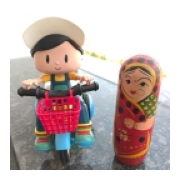

 CPU Backend Output :  (256, 256, 3)


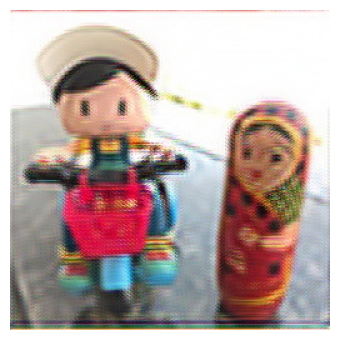

 HTP Backend Output :  (256, 256, 3)


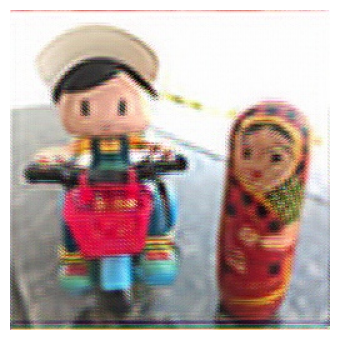

In [23]:
def display_image_in_actual_size(im_path):

    dpi = 80
    im_data = plt.imread(im_path)
    height, width, depth = im_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

print(" Original Image Input : ",img_org.shape)
display_image_in_actual_size("Original/sample.jpg")
print(" CPU Backend Output : ",img_fp32.shape)
display_image_in_actual_size("Results/fp_32/fp_32_enhanced.jpg")
print(" HTP Backend Output : ",img_int8.shape)
display_image_in_actual_size("Results/int_8/int_8_enhanced.jpg")